In [162]:
using POMDPs
using POMDPModels
using POMDPTools

# using Random

# using GridInterpolations
# using LocalFunctionApproximation
# using LocalApproximationValueIteration

using DiscreteValueIteration
using PolicyIteration


# solver = PolicyIterationSolver()
# mdp = SimpleGridWorld()
# mdp = SimpleGridWorld(
#     size = (50,50),
#     rewards = Dict(GWPos(x,y)=>10. for x ∈ 20:40, y ∈ 20:40)
# )
# mdp = SimpleGridWorld(
#     size = (100,100),
#     rewards = Dict(GWPos(x,y)=>10. for x ∈ 40:60, y ∈ 40:60)
# )

# grid_size = 100
# reward_grid = Dict{GWPos, Float64}()

d = 8

reward_grid = Dict{GWPos, Float64}();
reward_grid[GWPos(1, 1)] = 1
reward_grid[GWPos(d, 1)] = -1
# reward_grid[GWPos(1, d)] = -5

mdp = SimpleGridWorld(
size = (d,d),
rewards = reward_grid)


    
solver_vi = ValueIterationSolver(max_iterations=800, belres=1e-6, verbose=false) # creates the solver
solver_pi = PolicyIterationSolver(include_Q = true)
my_policy = PolicyIteration.solve(solver_pi, mdp); # runs policy iterations
# solver_approx = LocalApproximationValueIterationSolver(interp, verbose=false, max_iterations=1000, is_mdp_generative=false);
vi_policy = DiscreteValueIteration.solve(solver_vi, mdp)



EVALUTAION DONE at iteration: 5
EVALUTAION DONE at iteration: 29
EVALUTAION DONE at iteration: 28
EVALUTAION DONE at iteration: 28
Policy iteration terations: 4


ValueIterationPolicy:
 [1, 1] -> :up
 [2, 1] -> :left
 [3, 1] -> :left
 [4, 1] -> :left
 [5, 1] -> :left
 [6, 1] -> :left
 [7, 1] -> :left
 [8, 1] -> :up
 [1, 2] -> :down
 [2, 2] -> :left
 [3, 2] -> :left
 [4, 2] -> :left
 [5, 2] -> :left
 [6, 2] -> :left
 [7, 2] -> :left
 [8, 2] -> :left
 [1, 3] -> :down
 [2, 3] -> :down
 [3, 3] -> :left
 …

In [164]:
# file for rendering gridworld

using Colors
using Compose
using ColorSchemes
import POMDPTools: render
import POMDPTools.ModelTools: mean_reward

function render(mdp::SimpleGridWorld, step::Union{NamedTuple,Dict}=(;); color = s->reward(mdp, s), 
    policy::Union{Policy,Nothing} = nothing, colormin::Float64 = -10.0, colormax::Float64 = 10.0,
    val_func = nothing, qmat = nothing
   )

    color = tofunc(mdp, color)

    # color_gradient = Colors.gradient(:white, :blue)
    # cgrad([:gray, :white])

    nx, ny = mdp.size
    cells = []
    for x in 1:nx, y in 1:ny
        cell = cell_ctx((x,y), mdp.size)

        if policy !== nothing
            a = action(policy, GWPos(x,y))
            txt = compose(context(), text(0.5, 0.5, aarrow[a], hcenter, vcenter), stroke("black"), fill("black"))
            compose!(cell, txt)
        end
        
        clr = tocolor(color(GWPos(x,y)), colormin, colormax)
        compose!(cell, rectangle(), fill(clr), stroke("gray"))

        if val_func !== nothing
            value = val_func[(y - 1) * nx + x]
            # println("value: ", value)
            # value_txt = compose(context(), text(0.5, 0.5, string(round(value, digits = 3)), hcenter, vcenter), stroke("black"), fill("black"))
            clr = value_to_color(value, minimum(val_func), maximum(val_func))
            compose!(cell, rectangle(), fill(clr), stroke("gray"))
            # compose!(cell, value_txt, rectangle(), fill(clr), stroke("gray"))

        end

        if qmat !== nothing
            q_up = round(qmat[(y - 1) * nx + x, 1], digits=2)
            q_down = round(qmat[(y - 1) * nx + x, 2], digits=2)
            q_left = round(qmat[(y - 1) * nx + x, 3], digits=2)
            q_right = round(qmat[(y - 1) * nx + x, 4], digits=2)

            txt_down = compose(context(), text(0.5, 0.8, string(q_down), hcenter, vcenter), fontsize(6pt), stroke("black"))
            txt_up = compose(context(), text(0.5, 0.2, string(q_up), hcenter, vcenter), fontsize(6pt), stroke("black"))
            txt_left = compose(context(), text(0.2, 0.5, string(q_left), hcenter, vcenter), fontsize(6pt), stroke("black"))
            txt_right = compose(context(), text(0.8, 0.5, string(q_right), hcenter, vcenter), fontsize(6pt), stroke("black"))

            compose!(cell, txt_up, txt_down, txt_left, txt_right)
        end
        
        push!(cells, cell)
    end
    grid = compose(context(), linewidth(0.5mm), cells...)
    outline = compose(context(), linewidth(1mm), rectangle(), stroke("gray"))

    if haskey(step, :s)
        agent = cell_ctx(step[:s], mdp.size)
        if haskey(step, :a)
            act = compose(context(), text(0.5, 0.5, aarrow[step[:a]], hcenter, vcenter), stroke("black"), fill("black"))
            compose!(agent, act)
        end
        compose!(agent, circle(0.5, 0.5, 0.4), fill("orange"))
    else
        agent = nothing
    end

    if haskey(step, :sp) && !isterminal(mdp, step[:sp])
        next_agent = cell_ctx(step[:sp], mdp.size)
        compose!(next_agent, circle(0.5, 0.5, 0.4), fill("lightblue"))
    else
        next_agent = nothing
    end

    sz = min(w,h)
    return compose(context((w-sz)/2, (h-sz)/2, sz, sz), agent, next_agent, grid, outline)
    end

function cell_ctx(xy, size)
    nx, ny = size
    x, y = xy
    return context((x-1)/nx, (ny-y)/ny, 1/nx, 1/ny)
end

tocolor(x, colormin, colormax) = x

function tocolor(r::Float64, colormin::Float64, colormax::Float64)
    frac = (r-colormin)/(colormax-colormin)
    return get(ColorSchemes.redgreensplit, frac)
end

function value_to_color(val::Float64, colormin::Float64, colormax::Float64)
    frac = (val-colormin)/(colormax-colormin)
    return get(ColorSchemes.RdBu_9, frac)
end

tofunc(m::SimpleGridWorld, f) = f
tofunc(m::SimpleGridWorld, mat::AbstractMatrix) = s->mat[s...]
tofunc(m::SimpleGridWorld, v::AbstractVector) = s->v[stateindex(m, s)]

const aarrow = Dict(:up=>'↑', :left=>'←', :down=>'↓', :right=>'→')


Dict{Symbol, Char} with 4 entries:
  :left  => '←'
  :right => '→'
  :up    => '↑'
  :down  => '↓'

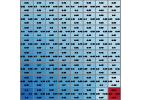

In [168]:
# include("gridworld_visualisation.jl")
render(mdp, val_func = my_policy.util, qmat = my_policy.qmat)
# render(gw)
# render(mdp, (s=[6,6],))

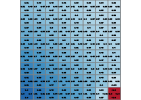

In [169]:
render(mdp, val_func = vi_policy.util, qmat = vi_policy.qmat)


In [ ]:
p = FunctionPolicy(s->:up)
steps = collect(stepthrough(gw, p, max_steps=100, rng=MersenneTwister(3)));

render(gw, steps[25])

In [ ]:
# Below is commented out for testing, but it can be used to explore the history

using Interact

@manipulate for i in 1:length(steps)
    render(gw, steps[i])
end

